In [70]:
import vqvae2

Results will be saved in ./results/vqvae_imagenetmon_mar_4_20_53_50_2024.pth


In [103]:
import transformers
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import utils
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encodings = torch.tensor(np.load("data/tiny-imagenet/vq-vae-embedding.npy")).cpu()

In [129]:
import torch.nn as nn
class PixelLSTM(nn.Module):
    def __init__(self):
        super(PixelLSTM, self).__init__()
        self.embed = torch.nn.Embedding(512, 128)
        self.lstm = torch.nn.GRU(128, 512, num_layers=1, batch_first=True, dropout=0.1)
        self.output = torch.nn.Linear(512,512)

    def forward(self, x, hidden_state=None):
        output, hidden_state = self.lstm(self.embed(x), hidden_state)
        return self.output(output), hidden_state
device="cuda"
model = PixelLSTM().to(device)
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

1314304

In [130]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data.to(device)
    def __getitem__(self, i):
        return self.data[i]
    def __len__(self):
        return self.data.shape[0]
lm_dataset = CustomDataset(encodings)
lm_loader = torch.utils.data.DataLoader(lm_dataset, batch_size=32, shuffle=True)

In [131]:
def predict(self, prefix, num_preds, vocab, device=device,temperature=1):
    """Defined in :numref:`sec_rnn-scratch`"""
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        output, state = self(X, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            with torch.no_grad():
                Y = torch.nn.functional.softmax(output.squeeze()/temperature, dim=0)
            l = Y.tolist()
            t = sum(l)
            l = [i/t for i in l]
            outputs.append(int(np.random.choice(vocab, p=l)))
    return torch.tensor(outputs).to(device)

In [132]:
def evaluate_model():
    with torch.no_grad():
        model.eval()
        e = predict(model, [8], 320-1, vocab=[i for i in range(512)], temperature=0.4)
        data = vqvae2.model.get_decode(e[:8*8].unsqueeze(0), e[8*8:].unsqueeze(0)).squeeze(0)
        scale_img = lambda x : (x+1)/2
        plt.imshow(scale_img(data.permute((1,2,0)).cpu().detach().numpy()))
        plt.show()

  0%|                                                  | 0/2915 [00:00<?, ?it/s]

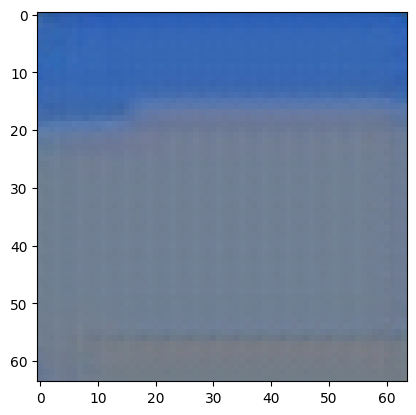

 34%|█████████████▍                         | 1000/2915 [00:13<00:26, 73.13it/s]

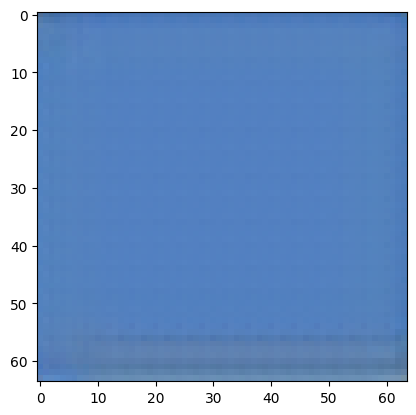

 69%|██████████████████████████▊            | 2000/2915 [00:27<00:12, 72.93it/s]

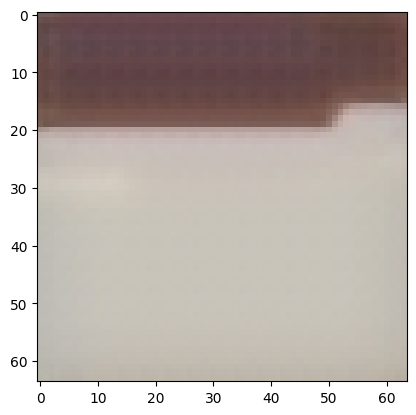

  0%|                                                  | 0/2915 [00:00<?, ?it/s]

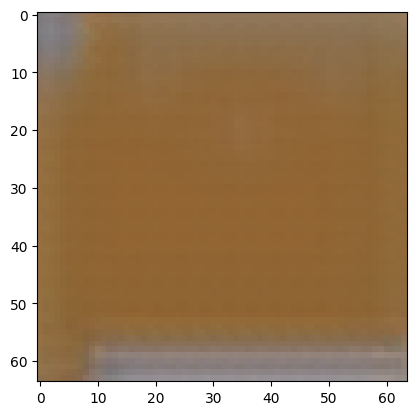

 12%|████▌                                   | 336/2915 [00:04<00:36, 70.52it/s]


KeyboardInterrupt: 

In [140]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
!rm lstm_log -rf
writer = SummaryWriter(log_dir="lstm_log/")

epoch = 10
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

n_iter = 0
for i in range(epoch):
    for index, x in tqdm(enumerate(lm_loader),total=len(lm_loader)):
        model.train()
        n_iter += 1
        optimizer.zero_grad(set_to_none=True)
        with torch.no_grad():
            label = x.roll(-1,dims=1)
        z, _ = model(x)
        z = z.permute((0,2,1))
        loss = loss_func(z, label)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            accuracy = torch.sum(z.argmax(1) == label) / (label.shape[1]*label.shape[0])
            writer.add_scalar("loss", loss.item(), n_iter)
            writer.add_scalar("acc", accuracy.item() ,n_iter)
        if index % 1000 == 0:
            evaluate_model()

In [ ]:
def show_image(n_iter, id = 8, clip=False):
    f, axarr = plt.subplots(2, id, figsize=(id*4, 8))
    model.eval()
    scale_img = lambda x : (x+1)/2
    for i in range(0, id):
        data = training_data[i][0]
        axarr[0][i].axis("off")
        axarr[0][i].imshow(scale_img(data.permute((1,2,0)).cpu().detach().numpy()))
        with torch.no_grad():
            _, output, _ = model(data.unsqueeze(0).to(device))
        if clip:
            output = torch.clip(output, min=-1,max=1)
        output = scale_img(output)
        output = output.squeeze(0).permute((1,2,0)).cpu().detach().numpy()
        axarr[1][i].axis("off")
        axarr[1][i].imshow(output)
    f.suptitle("Face plot"+str(n_iter))
    plt.savefig("plot/"+type(model).__name__ + str(n_iter) + ".png")
    plt.show()